In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Terezka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Terezka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Terezka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [2]:
df_raw = pd.read_csv('sweetmarias_dataset.csv')
df_raw.shape

(326, 38)

In [3]:
df_raw.columns

Index(['ID', 'Name', 'Variety', 'Country', 'Region', 'Processing', 'Drying',
       'Dry.Fragrance', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Correction',
       'Total.Cup.Points', 'flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body', 'geo_lat', 'geo_lng', 'specs_grade',
       'specs_arrival_date', 'url', 'overview', 'cup_description'],
      dtype='object')

In [4]:
max_countries = df_raw.Country.value_counts()
max_countries = max_countries[max_countries >= 25]
print(max_countries.index)
df_raw = df_raw[df_raw.Country.isin(max_countries.index)]

Index(['Ethiopia', 'Guatemala', 'Kenya', 'Colombia', 'Indonesia'], dtype='object')


In [60]:
df_raw.Country.value_counts()

Ethiopia     42
Guatemala    40
Kenya        36
Colombia     30
Indonesia    28
Name: Country, dtype: int64

In [5]:
df_raw.Country.unique()

array(['Colombia', 'Ethiopia', 'Indonesia', 'Guatemala', 'Kenya'],
      dtype=object)

In [6]:
X_flavor, y_flavor = df_raw.loc[:, df_raw.columns.str.contains('flavor')], df_raw.Country
print(X_flavor.shape)
X_flavor.head(3)

(176, 12)


flavor_floral  flavor_honey  flavor_sugars  flavor_caramel  flavor_fruits  \
29            0.0           0.0            3.0             0.0            3.0   
30            0.0           0.0            3.0             0.0            3.0   
31            0.0           0.0            3.0             0.0            3.0   

    flavor_citrus  flavor_berry  flavor_cocoa  flavor_nuts  flavor_rustic  \
29            1.0           3.0           3.0          0.0            2.5   
30            1.0           3.0           2.0          0.0            1.0   
31            0.0           2.0           3.5          0.0            1.0   

    flavor_spice  flavor_body  
29           2.0          4.0  
30           1.0          4.0  
31           2.0          4.0

In [7]:
X_flavor.describe()

flavor_floral  flavor_honey  flavor_sugars  flavor_caramel  \
count     176.000000    176.000000     176.000000      176.000000   
mean        0.715909      0.755682       3.238636        1.156250   
std         1.121976      1.099336       0.495565        1.202267   
min         0.000000      0.000000       1.500000        0.000000   
25%         0.000000      0.000000       3.000000        0.000000   
50%         0.000000      0.000000       3.000000        1.000000   
75%         1.500000      2.000000       3.500000        2.000000   
max         4.000000      3.500000       4.000000        4.000000   

       flavor_fruits  flavor_citrus  flavor_berry  flavor_cocoa  flavor_nuts  \
count     176.000000     176.000000    176.000000    176.000000   176.000000   
mean        2.096591       1.167614      1.343750      2.701705     0.428977   
std         0.988095       1.160801      1.226966      1.545666     0.747805   
min         0.000000       0.000000      0.000000      0.000000     0.000000   
25%         1.500000       0.000000      0.000000      2.000000     0.000000   
50%         2.500000       1.000000      1.250000      3.000000     0.000000   
75%         3.000000       2.500000      2.500000      4.000000     1.000000   
max         4.000000       3.500000      4.000000      5.000000     2.500000   

       flavor_rustic  flavor_spice  flavor_body  
count     176.000000    176.000000   176.000000  
mean        0.747159      1.241477     3.875000  
std         1.078355      1.039195     0.429285  
min         0.000000      0.000000     3.000000  
25%         0.000000      0.000000     3.500000  
50%         0.000000      1.500000     4.000000  
75%         1.500000      2.000000     4.000000  
max         4.000000      3.000000     5.000000

In [8]:
cupping_score = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
                 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness']

X_cup, y_cup = df_raw[cupping_score], df_raw.Country
print(X_cup.shape)
X_cup.head(3)

(176, 9)


Aroma  Flavor  Aftertaste  Acidity  Body  Balance  Uniformity  Clean.Cup  \
29    8.8     8.8         8.2      8.5   9.0      9.2         8.5        8.0   
30    8.9     9.0         8.7      8.7   9.0      9.1         8.3        8.4   
31    8.9     9.0         8.7      8.4   9.0      9.1         8.5        8.2   

    Sweetness  
29        8.6  
30        8.7  
31        8.7

In [9]:
X_cup.describe()

Aroma      Flavor  Aftertaste     Acidity        Body     Balance  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     8.943182    8.952273    8.655682    8.605114    8.910795    9.034659   
std      0.380765    0.349686    0.516440    0.433362    0.347312    0.471221   
min      7.300000    8.200000    7.000000    6.500000    8.000000    7.800000   
25%      8.700000    8.700000    8.300000    8.400000    8.700000    8.700000   
50%      8.850000    9.000000    8.650000    8.600000    9.000000    9.200000   
75%      9.300000    9.300000    9.100000    8.900000    9.200000    9.500000   
max      9.700000    9.600000    9.600000    9.500000   10.000000   10.000000   

       Uniformity   Clean.Cup   Sweetness  
count  176.000000  176.000000  176.000000  
mean     8.641477    8.469318    8.788636  
std      0.390657    0.544659    0.277306  
min      7.800000    7.000000    7.300000  
25%      8.450000    8.200000    8.600000  
50%      8.500000    8.500000    8.800000  
75%      9.000000    9.000000    9.000000  
max     10.000000    9.500000    9.500000

In [10]:
df_bag = pd.DataFrame({'country': df_raw.Country, 'description': df_raw.overview + df_raw.cup_description})
df_bag.head(3)

country                                        description
29  Colombia  Heavy-handed cup profile that touches on winey...
30  Colombia  Cup flavors encapsulate juicy sweetness, flavo...
31  Colombia  Both light and darker roasts are delicious, wi...

In [11]:
country_words = df_raw.Country.unique().tolist()
region_words = df_raw.Region.dropna().unique().tolist()
farms = [(d) for d in df_raw.cup_description if 'farm' in d]
print(farms)
country_words

["This single farm coffee from Idido has a honey-sweet smell to the dry fragrance, with fruited suggestions of dried tropical fruits and berries. I felt like the identifiable smells multiplied by tenfold after pouring hot water! There's a scent of ripe berries and other fruits, as well as floral/herbal notes that ride the line between fresh rue and jasmine. My darkest Full City roast showed rustic bittersweetness in the wet aroma, juxtaposed by a delicious smelling note of dried blueberry. In the cup, City roasts have a dried blueberry note, that along with herbal honey accents, brought to mind honey granola with fruits. The cup flavors reveal much more fruit in the profile as the coffee cools, but at a lower level of intensity than some of our other dry process Ethiopias. In that way, it reminded me of some of the fruitier wet process Ethiopian coffees we've had. An aromatic peach note comes up in the profile, with notes of dried apricot, and some aromatic bittering that reminded me o

['Colombia', 'Ethiopia', 'Indonesia', 'Guatemala', 'Kenya']

In [12]:
# remove location info
def preprocess_names(names, stemmer, to_remove):
   names = [n.translate(str.maketrans("", "", string.punctuation)) for n in names]
   names = [n.split(' ') for n in names]
   return [stemmer.stem(word) for name in names for word in name if not word.lower() in to_remove]

In [13]:
stemmer = SnowballStemmer('english')
en_stopwords = stopwords.words('english')

stem_country = preprocess_names(country_words, stemmer, en_stopwords)
stem_region = preprocess_names(region_words, stemmer, en_stopwords)

### Text preprocessing
Text description preprocessing functions

Removing location information:
- country names
- region names
- farm names (upper caps before farm keyword)
- upper caps (except sentence beggining) - problem: moves also e.g Full City, tea name flavour

In [14]:
def remove_farm_name(i, words):
    words[i] = words[i].lower()
    i -= 1
    # is a name (starts with upper case)
    while words[i][0].isupper():
        words[i] = ""
        i -= 1

def remove_words(words_bag, words_remove):
    return [w for w in words_bag if not any(map(lambda restricted: restricted in w, words_remove))]

In [15]:
def preprocess_description(description, stemmer, stopwords, stem_country, stem_region):
    # remove words starting with upper case (to catch most of the location names)
    sentences = description.split('.')
    cleaned_words = []
    
    for s in sentences:
        split_s = s.split()

        if (len(split_s) == 0):
            continue
        
        # keep first word of the sentence -- will be checked later
        cleaned_words.append(split_s[0])

        if (len(split_s) == 1):
            continue
    
        # remove words starting with upper case (to catch most of the location names)
        [cleaned_words.append(word) for word in split_s[1:] if not word[0].isupper()]
    
    description = ' '.join(cleaned_words)

    # create word bag
    description = ' '.join(description.translate(str.maketrans(string.punctuation, " " * len(string.punctuation))).split())
    words = word_tokenize(description)
    
    # remove farm names
    no_farm_words = words.copy()
    for i in range(len(words)):
        if 'farm' in words[i].lower():
            remove_farm_name(i, no_farm_words)

    words = [w for w in no_farm_words if not w == '']

    # stem and remove stopwords
    stem_words = [stemmer.stem(w) for w in words if not w.lower() in stopwords]

    # remove location info extracted from country and region features
    stem_words = remove_words(stem_words, stem_country)
    stem_words = remove_words(stem_words, stem_region)

    return stem_words    

In [16]:
# example of preprocessed description output
print(df_bag.description.iloc[0])
print(df_bag.description.apply(lambda x: preprocess_description(x, stemmer, en_stopwords, stem_country, stem_region)).iloc[0])

Heavy-handed cup profile that touches on winey fruits and rustic sweetness. Prune juice, apples cooked with cinnamon, plum wine, stewed cherries with some skin bittering, and cocoa bittersweetness that lingers. City to Full City.Cristian Martinez' coffee is one of our final from Aponte, and as a honey process lot, shows fairly wild fruit characteristics in the cup. The dry fragrance is fruited with baked apple and tamarind, with a note of cinnamon, and raw sugars that are lightly accented by an herbal hint. The wet aroma plays sugars and fruit off each other quite nicely, and leads me down a cooked fruit jam, and berry reduction path. Fruits were a big part of the cup profile in my light and medium roasts. This is not a "refined" coffee, but rather loaded with heavy-handed flavors that touch on winey fruits and rustic sweetness too. My City+ roast highlighted flavors of prune juice, apples cooked with cinnamon, plum wine, and stewed cherries with some skin bittering in there. I like th

# Models

## Baseline model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_raw.drop('Country', axis=1), df_raw.Country, random_state=42)

In [61]:
y_train.value_counts()

Ethiopia     34
Kenya        28
Guatemala    26
Indonesia    24
Colombia     20
Name: country, dtype: int64

In [62]:
y_test.value_counts()

Guatemala    14
Colombia     10
Kenya         8
Ethiopia      8
Indonesia     4
Name: country, dtype: int64

In [64]:
baseline_most_stratified = DummyClassifier(strategy='stratified', random_state=42)
baseline_most_stratified.fit(X_train, y_train)
y_pred = baseline_most_stratified.predict(X_test)
base_strat_score = f1_score(y_test, y_pred, average='weighted')
print("Baseline model stratified:", base_strat_score)

Baseline model stratified: 0.1336911606180381


## TF-IDF + SGD model

In [65]:
X = df_bag.description
y = df_bag.country

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [66]:
def get_word_bag(x):
    return preprocess_description(x, stemmer, en_stopwords, stem_country, stem_region)

In [67]:
pipe = make_pipeline(TfidfVectorizer(analyzer=get_word_bag), SGDClassifier(loss='log_loss'))

In [68]:
text_score = cross_val_score(pipe, X_train, y_train, scoring='f1_weighted')
print(text_score, text_score.mean())

[0.85253019 0.8030118  0.87541091 0.83169907 0.67541091] 0.8076125773561671


In [69]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict((X_test))
text_f1 = f1_score(y_test, y_pred, average='weighted')
text_f1

0.904664453193865

Text(50.72222222222221, 0.5, 'True label')

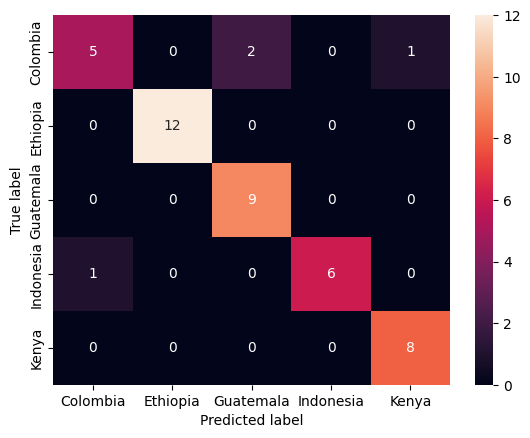

In [70]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")

### Model application
Examples of the model applied on a short descriptions found on different coffee websites.

In [71]:
all_data_pipe = make_pipeline(TfidfVectorizer(analyzer=get_word_bag), SGDClassifier(loss='log_loss'))
all_data_pipe.fit(X, y)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer=<function get_word_bag at 0x000001ACFEB896C0>)),
                ('sgdclassifier', SGDClassifier(loss='log_loss'))])

In [72]:
def show_prediction(text, label):
    print(text)
    print(get_word_bag(text))
    print("True:", label)
    print("Predicted:", all_data_pipe.predict([text])[0])
    print("Probabilities:")
    print(all_data_pipe.classes_.tolist())
    print(all_data_pipe.predict_proba([text])[0])

In [73]:
ethiopia1 = "Its fruitiness is reminiscent of ripe melon with peach and the aftertaste has interesting hints of hibiscus."
ethiopia2 = "Ethiopia is the birthplace of coffee and is home to many of the best coffees in the world. Inspired by their floral and citrusy notes, we use 100 Ethiopian coffee in Apollo, for a coffee that tastes silky, sweet, and bright."
columbia1decaf = "A delicious cup of decaf is a beautiful thing. This lot was harvested by the producers of K’uychi in Nariño, Colombia, and decaffeinated at Colombia’s only decaffeination plant, which uses a derivative of sugarcane, called ethyl acetate, in the process. The result is one of the sweetest and most complex cups of decaf we've ever tasted, with notes of black cherry, dried date, and molasses. "
columbia1censored = "A delicious cup of * is a beautiful thing. This lot was harvested by the producers of K’uychi in Nariño, Colombia, and * at Colombia’s only decaffeination plant, which uses a derivative of sugarcane, called ethyl acetate, in the process. The result is one of the sweetest and most complex cups of decaf we've ever tasted, with notes of black cherry, dried date, and molasses. "
kenya1 = "A genetic mutation separated during the dry milling phase, this rare peaberry lot from the Kagumo mill boasts a deep brown sugar sweetness with the citric acidity like grapefruit. Roasted for a round tactile and heavy sweetness, this coffee performs well on filter and espresso."
kenya2 = "This washed heirloom variety from the Bensa region falls within the coveted category of archetypal coffees. Boasting ripe apricot sweetness and delicate florals like jasmine, this Shantawene has been picked and processed to perfection. This lot is the reason why we return to the Bensa region time and time again for washed and natural processed offerings. Performing exceedingly well as a filter offering, you'll find your space filled with sweet florals as soon as water hits this brew."
kenya2short = "apricot, citra hops, tangerine jasmine"

In [74]:
# the model predicts correctly
show_prediction(ethiopia1, "Ethiopia")

Its fruitiness is reminiscent of ripe melon with peach and the aftertaste has interesting hints of hibiscus.
['fruiti', 'reminisc', 'ripe', 'melon', 'peach', 'aftertast', 'interest', 'hint', 'hibiscus']
True: Ethiopia
Predicted: Ethiopia
Probabilities:
['Colombia', 'Ethiopia', 'Guatemala', 'Indonesia', 'Kenya']
[0.07812409 0.5548439  0.10777736 0.18396091 0.07529374]


In [75]:
# the model predicts incorrectly
show_prediction(kenya1, "Kenya")

A genetic mutation separated during the dry milling phase, this rare peaberry lot from the Kagumo mill boasts a deep brown sugar sweetness with the citric acidity like grapefruit. Roasted for a round tactile and heavy sweetness, this coffee performs well on filter and espresso.
['genet', 'mutat', 'separ', 'dri', 'mill', 'phase', 'rare', 'peaberri', 'lot', 'mill', 'boast', 'deep', 'brown', 'sugar', 'sweet', 'citric', 'acid', 'like', 'grapefruit', 'roast', 'round', 'tactil', 'heavi', 'sweet', 'coffe', 'perform', 'well', 'filter', 'espresso']
True: Kenya
Predicted: Guatemala
Probabilities:
['Colombia', 'Ethiopia', 'Guatemala', 'Indonesia', 'Kenya']
[0.24388917 0.07433056 0.29616085 0.21672054 0.16889888]


In [76]:
# the model is incorrect partly because of the decaf keyword bias
show_prediction(columbia1decaf, "Colombia")

A delicious cup of decaf is a beautiful thing. This lot was harvested by the producers of K’uychi in Nariño, Colombia, and decaffeinated at Colombia’s only decaffeination plant, which uses a derivative of sugarcane, called ethyl acetate, in the process. The result is one of the sweetest and most complex cups of decaf we've ever tasted, with notes of black cherry, dried date, and molasses. 
['delici', 'cup', 'decaf', 'beauti', 'thing', 'lot', 'harvest', 'produc', 'decaffein', 'decaffein', 'plant', 'use', 'deriv', 'sugarcan', 'call', 'ethyl', 'acet', 'process', 'result', 'one', 'sweetest', 'complex', 'cup', 'decaf', 'ever', 'tast', 'note', 'black', 'cherri', 'dri', 'date', 'molass']
True: Colombia
Predicted: Ethiopia
Probabilities:
['Colombia', 'Ethiopia', 'Guatemala', 'Indonesia', 'Kenya']
[0.29341418 0.35624087 0.06093099 0.22961147 0.05980249]


In [77]:
# when the decaf keyword is removed, the model shifts probabilities to Columbia and Indonesia
show_prediction(columbia1censored, "Colombia")

A delicious cup of * is a beautiful thing. This lot was harvested by the producers of K’uychi in Nariño, Colombia, and * at Colombia’s only decaffeination plant, which uses a derivative of sugarcane, called ethyl acetate, in the process. The result is one of the sweetest and most complex cups of decaf we've ever tasted, with notes of black cherry, dried date, and molasses. 
['delici', 'cup', 'beauti', 'thing', 'lot', 'harvest', 'produc', 'decaffein', 'plant', 'use', 'deriv', 'sugarcan', 'call', 'ethyl', 'acet', 'process', 'result', 'one', 'sweetest', 'complex', 'cup', 'decaf', 'ever', 'tast', 'note', 'black', 'cherri', 'dri', 'date', 'molass']
True: Colombia
Predicted: Colombia
Probabilities:
['Colombia', 'Ethiopia', 'Guatemala', 'Indonesia', 'Kenya']
[0.32437379 0.24505386 0.05593226 0.30468123 0.06995886]


## Random Forest Classifier

### Flavor attributes

In [78]:
X_train_flavor, X_test_flavor, y_train_flavor, y_test_flavor = train_test_split(X_flavor, y_flavor, random_state=42)

In [79]:
rdf = RandomForestClassifier(n_estimators=100, max_features=5, class_weight='balanced')
flavor_score = cross_val_score(rdf, X_train_flavor, y_train_flavor)
print(flavor_score, np.mean(flavor_score))

[0.77777778 0.66666667 0.76923077 0.61538462 0.57692308] 0.6811965811965812


In [80]:
rdf.fit(X_train_flavor, y_train_flavor)
y_pred_flavor = rdf.predict(X_test_flavor)
flavour_f1 = f1_score(y_test_flavor, y_pred_flavor, average='weighted')
flavour_f1

0.6839990817263545

Text(50.72222222222221, 0.5, 'True label')

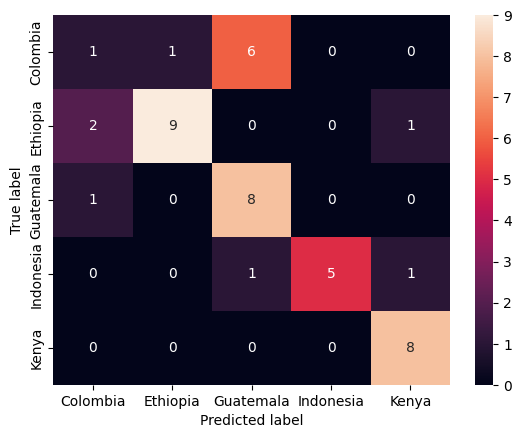

In [81]:
matrix = confusion_matrix(y_test_flavor, y_pred_flavor)
ax = sns.heatmap(matrix, annot=True, xticklabels=rdf.classes_, yticklabels=rdf.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")

### Cupping score attributes

In [82]:
X_train_cup, X_test_cup, y_train_cup, y_test_cup = train_test_split(X_cup, y_cup, random_state=42)

In [83]:
rdf_cup = RandomForestClassifier(n_estimators=100, max_features=5, class_weight='balanced') 
cup_score = cross_val_score(rdf_cup, X_train_cup, y_train_cup)
print(cup_score, np.mean(cup_score))

[0.7037037  0.7037037  0.53846154 0.73076923 0.53846154] 0.643019943019943


In [84]:
rdf_cup.fit(X_train_cup, y_train_cup)
y_pred_cup = rdf_cup.predict(X_test_cup)
cup_f1 = f1_score(y_test_cup, y_pred_cup, average='weighted')
cup_f1

0.6146005509641873

Text(50.72222222222221, 0.5, 'True label')

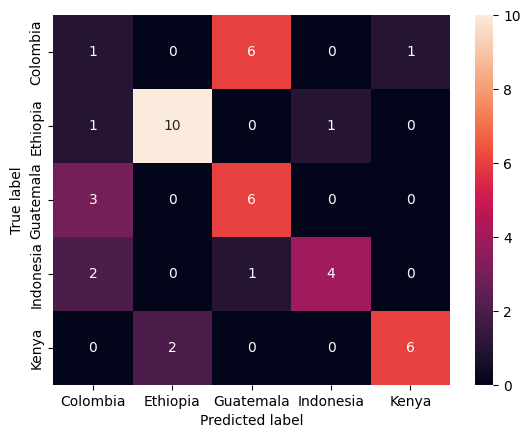

In [92]:
matrix = confusion_matrix(y_test_cup, y_pred_cup)
ax = sns.heatmap(matrix, annot=True, xticklabels=rdf_cup.classes_, yticklabels=rdf_cup.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")

## Combining SGD and RFC model
Combines class probabilities from the text model and the flavour model

In [86]:
print(y_test.tolist())
print(y_test_flavor.tolist())

['Colombia', 'Ethiopia', 'Kenya', 'Ethiopia', 'Ethiopia', 'Colombia', 'Kenya', 'Indonesia', 'Guatemala', 'Kenya', 'Colombia', 'Indonesia', 'Ethiopia', 'Kenya', 'Colombia', 'Guatemala', 'Guatemala', 'Guatemala', 'Colombia', 'Guatemala', 'Colombia', 'Ethiopia', 'Ethiopia', 'Indonesia', 'Indonesia', 'Kenya', 'Indonesia', 'Ethiopia', 'Guatemala', 'Ethiopia', 'Colombia', 'Kenya', 'Kenya', 'Ethiopia', 'Colombia', 'Ethiopia', 'Indonesia', 'Kenya', 'Guatemala', 'Indonesia', 'Ethiopia', 'Guatemala', 'Guatemala', 'Ethiopia']
['Colombia', 'Ethiopia', 'Kenya', 'Ethiopia', 'Ethiopia', 'Colombia', 'Kenya', 'Indonesia', 'Guatemala', 'Kenya', 'Colombia', 'Indonesia', 'Ethiopia', 'Kenya', 'Colombia', 'Guatemala', 'Guatemala', 'Guatemala', 'Colombia', 'Guatemala', 'Colombia', 'Ethiopia', 'Ethiopia', 'Indonesia', 'Indonesia', 'Kenya', 'Indonesia', 'Ethiopia', 'Guatemala', 'Ethiopia', 'Colombia', 'Kenya', 'Kenya', 'Ethiopia', 'Colombia', 'Ethiopia', 'Indonesia', 'Kenya', 'Guatemala', 'Indonesia', 'Ethiopi

In [87]:
flavor_prob = rdf.predict_proba(X_test_flavor)
text_prob = pipe.predict_proba(X_test)

combined_prob = ((flavor_prob * 0.5 + text_prob * 0.5)).round(3)
labels = pipe.classes_

combined_pred = combined_prob.argmax(axis=1)
combined_pred = np.vectorize(lambda x : labels[x]) (combined_pred)

comb_f1 = f1_score(y_test, combined_pred, average='weighted')
comb_f1

0.8779162014456131

<Axes: >

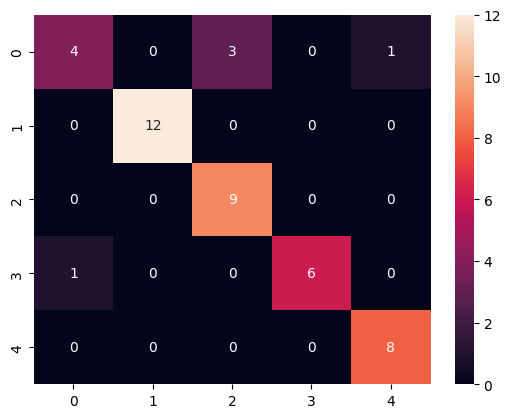

In [88]:
sns.heatmap(confusion_matrix(y_test, combined_pred), annot=True)

## Summary
Model cross-validation F1 scores obtained on the training dataset

In [89]:
print("Predicting from description:", text_score.mean().round(3))
print("Predicting from flavor:", flavor_score.mean().round(3))
print("Predicting from cupping score:", cup_score.mean().round(3))

Predicting from description: 0.808
Predicting from flavor: 0.681
Predicting from cupping score: 0.643


Model F1 scores obtained on the test dataset

In [91]:
print("Predicting from description:", text_f1.round(3))
print("Predicting from flavor:", flavour_f1.round(3))
print("Predicting from cupping score:", cup_f1.round(3))
print("Predicting from the combined description an flavour probabilities:", comb_f1.round(3))
print()
print("Baseline model (stratified):", base_strat_score.round(3))

Predicting from description: 0.905
Predicting from flavor: 0.684
Predicting from cupping score: 0.615
Predicting from the combined description an flavour probabilities: 0.878

Baseline model (stratified): 0.134
